In [247]:
#Imports
import time

import numpy as np
from scipy.stats import norm
import gurobipy as gb
import matplotlib.pyplot as plt

#Set seed for reproducibility of instances
np.random.seed(25)

def instance_generator(n=50000):
    '''
    Function that generates hard Knapsack problem instances.
    Input:
        -n: desired size of set of items I, defaulted at 50,000 as we use this number in our study
    Returns:
        -v: array of values for all i items
        -w: array of weights of all i items
    
    ''' 
    v = np.round(norm.rvs(100, 10, size=n))
    w = np.zeros(n)
    for i in range(n):
        w[i] = round(norm.rvs(v[i], 5))
    return v, w

v, w = instance_generator()

# Problem size set-up
#N = [50, 100, 500, 1000, 5000, 10000, 50000]
N = [50, 100, 500, 1000]

# Capacity constraint function based on the problem size
def W(n):
    return 0.9*np.sum(w[0:n])

In [237]:
# Binary problem
def binary_method(n, v=v, w=w):
    '''
    Function that runs the Gurobi-binary problem.
    Input:
        -n: Input problem size
    Output:
        -obj_val: Outcome of the optimizatoin
        -running_time: Time to run the algorithm on the problem size
    '''
    # Selecting relevant i for problem size, and calculate knapsack capacity
    W_gb = int(W(n))

    start_time = time.time()

    m = gb.Model("Binary model")
    x = m.addVars(n, vtype=gb.GRB.BINARY, name="x")

    m.setObjective(gb.quicksum(v[i]*x[i] for i in range(n)), gb.GRB.MAXIMIZE)

    m.addConstr(gb.quicksum(w[i]*x[i] for i in range(n)) <= W_gb)

    m.update()
    m.Params.LogToConsole = 0
    m.optimize()
    
    obj_val = m.objVal
    running_time = time.time() - start_time
    # print(len([i for i in range(n) if x[i].X==1]))
    return obj_val, running_time    

In [238]:
binary_method(50)

(2588.0, 0.007006406784057617)

In [239]:
optimal_solution_binary = [binary_method(n)[0] for n in N]
running_time_binary = [binary_method(n)[1] for n in N]

In [240]:

# Dynamic programming
def dyn_prog_method(n, v=v, w=w):
    
    # Selecting relevant i for problem size, and calculate knapsack capacity
    W_dp = int(W(n))

    # Start runtime measurement
    start_time = time.time()

    # Create table for bottom up dynamic programming
    OPT_table = [[0 for i in range(W_dp+1)] for i in range(n+1)]
    
    
    for i in range(1, n+1):
        for j in range(1, W_dp+1):
            #if i==0 or j == 0:
            #    OPT_table[i][j]=0
            #el
            if w[i-1] <= j:
                OPT_table[i][j] = max(OPT_table[i-1][j], v[i-1]+ OPT_table[i-1][int(j-w[i-1])])
            else:
                OPT_table[i][j] = OPT_table[i-1][j]

    # End runtime measurement
    running_time = time.time() - start_time

    # Return the value in the knapsack and the running time
    return OPT_table[n][W_dp], running_time    


In [241]:
optimal_solution_dyn_prog = [dyn_prog_method(n)[0] for n in N]
running_time_dyn_prog = [dyn_prog_method(n)[1] for n in N]

In [242]:
dyn_prog_method(50)

(2588.0, 0.15755319595336914)

In [243]:

# Greedy Hueristic
def Greedy_method(n, v=v, w=w):
    
    # Selecting relevant i for problem size, and calculate knapsack capacity
    W_gy = int(W(n))

    # Start runtime measurement
    start_time = time.time()

    # Calculate ratios
    ratios = [(v[i] /w[i], v[i], w[i]) for i in range(n) ]
    
    ratios.sort(reverse=True)

    # to 
    Weight_in_knapsack = 0
    value_in_knapsack = 0

    for ratio, value, weight in ratios:
        if Weight_in_knapsack + weight <= W_gy:
            value_in_knapsack += value
            Weight_in_knapsack += weight

    # End runtime measurement
    running_time = time.time() - start_time

    # Return the value in the knapsack and the running time
    return value_in_knapsack, running_time    


In [244]:
optimal_solution_greedy = [Greedy_method(n)[0] for n in N]
running_time_greedy = [Greedy_method(n)[1] for n in N]

In [245]:
Greedy_method(50)

(2583.0, 0.0010020732879638672)

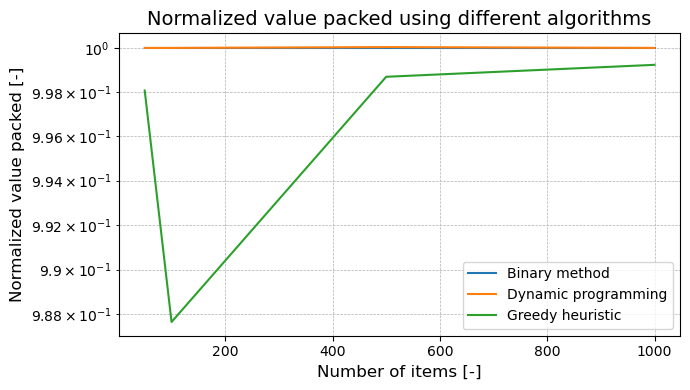

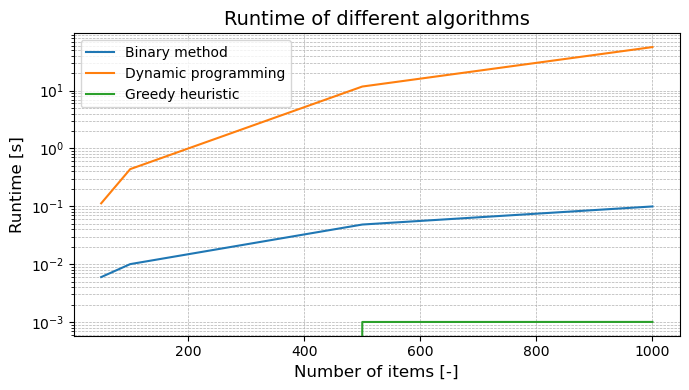

In [249]:
plt.figure(figsize=(7, 4))
plt.plot(N, [[1] for i in range(len(N))], label='Binary method')
plt.plot(N, [(optimal_solution_dyn_prog[i] /optimal_solution_binary[i]) for i in range(len(N))], label='Dynamic programming')
plt.plot(N, [(optimal_solution_greedy[i] /optimal_solution_binary[i]) for i in range(len(N))], label='Greedy heuristic')

plt.xlabel('Number of items [-]', fontsize=12)
plt.ylabel('Normalized value packed [-]', fontsize=12)
plt.title('Normalized value packed using different algorithms', fontsize=14)
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(N, running_time_binary, label='Binary method')
plt.plot(N, running_time_dyn_prog, label='Dynamic programming')
plt.plot(N, running_time_greedy, label='Greedy heuristic')

plt.xlabel('Number of items [-]', fontsize=12)
plt.ylabel('Runtime [s]', fontsize=12)
plt.title('Runtime of different algorithms', fontsize=14)
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()